### Recipe to evaluate model SST with satellite image product 


**This recipe will show a simple example onto how to evaluate the model SST over a satellite image. In this example, the satellite image product chosen is OSTIA, but it can be applicable to any dataset. Examples for the timemean and seasonal cycle will be given**

Steps:
- Read model and satellite data
- Interpolate the higher-resolution data to the coarser to get the same points and same area
- Calculate the time-mean
- Check the differences
- Calculate the seasonality and compare


It assumes:
- You have in hands the satellite products and the roms output. You can donwload OSTIA dataset using our Real-time script (RT_download_copernicus.py)


Fernando Sobral - 20th Feb 2025


In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

In [ ]:
# Reading the data. Adjust the path according to where your data is and its name.

roms = xr.open_dataset('roms_sst/roms_sst_30d.nc').temp
ostia_all = xr.open_dataset('ostia_data/METOFFICE-GLO-SST-L4-REP-OBS-SST_analysed_sst_142.02E-169.98E_44.97S-15.02S_2009-01-01-2010-12-31.nc').analysed_sst - 273.15


In [23]:
# Selecting the same time from roms in ostia

ostia = ostia_all.sel(time=roms.ocean_time.values)

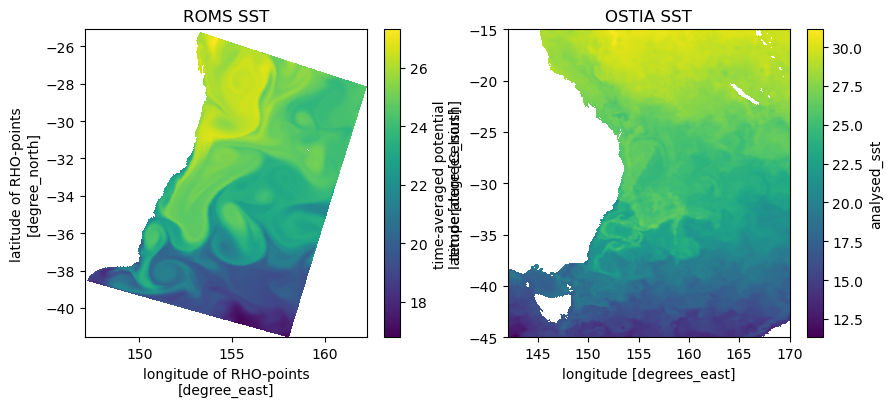

In [ ]:
# Checking one day for our SST roms data

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

roms.isel(ocean_time=0).plot(ax=ax[0], x='lon_rho', y='lat_rho')
ax[0].set_title('ROMS SST')

ostia.isel(time=0).plot(ax=ax[1], x='longitude', y='latitude')
ax[1].set_title('OSTIA SST');

In [26]:
# Checking grid resolution (OSTIA is 0.05° and ROMS is variable from 0.02 to 0.06)

lon_roms = roms.lon_rho.values
lat_roms = roms.lat_rho.values

lon_ostia = ostia.longitude.values
lat_ostia = ostia.latitude.values

print('ROMS grid resolution:', lon_roms[0, 1] - lon_roms[0, 0], lat_roms[1, 0] - lat_roms[0, 0])
print('OSTIA grid resolution:', lon_ostia[1] - lon_ostia[0], lat_ostia[1] - lat_ostia[0])

ROMS grid resolution: 0.03247192783149444 0.04234901231472321
OSTIA grid resolution: 0.05000305 0.049999237


In [38]:
# Interpolate ROMS grid to OSTIA grid (higher resolution into coarser resolution)
LON, LAT = np.meshgrid(lon_ostia, lat_ostia)

# Flatten the arrays for interpolation
points = np.array([lon_roms.ravel(), lat_roms.ravel()]).T

# List to store regridded time steps
regridded_list = []

for TT in roms.ocean_time.values:
    print(TT)

    # Extract values for the current time step
    values = roms.sel(ocean_time=TT).values.ravel()

    # Interpolate onto OSTIA grid
    interpolated = griddata(points, values, (LON, LAT), method='linear')

    # Convert interpolated result to a DataArray with correct dimensions
    interpolated_da = xr.DataArray(
        interpolated,
        dims=("latitude", "longitude"),
        coords={"latitude": lat_ostia, "longitude": lon_ostia, "time": TT},
    )

    # Append to list
    regridded_list.append(interpolated_da)

# Concatenate along time dimension
roms_regrided = xr.concat(regridded_list, dim="time")

2009-03-14T00:00:00.000000000
2009-03-15T00:00:00.000000000
2009-03-16T00:00:00.000000000
2009-03-17T00:00:00.000000000
2009-03-18T00:00:00.000000000
2009-03-19T00:00:00.000000000
2009-03-20T00:00:00.000000000
2009-03-21T00:00:00.000000000
2009-03-22T00:00:00.000000000
2009-03-23T00:00:00.000000000
2009-03-24T00:00:00.000000000
2009-03-25T00:00:00.000000000
2009-03-26T00:00:00.000000000
2009-03-27T00:00:00.000000000
2009-03-28T00:00:00.000000000
2009-03-29T00:00:00.000000000
2009-03-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-04-01T00:00:00.000000000
2009-04-02T00:00:00.000000000
2009-04-03T00:00:00.000000000
2009-04-04T00:00:00.000000000
2009-04-05T00:00:00.000000000
2009-04-06T00:00:00.000000000
2009-04-07T00:00:00.000000000
2009-04-08T00:00:00.000000000
2009-04-09T00:00:00.000000000
2009-04-10T00:00:00.000000000
2009-04-11T00:00:00.000000000
2009-04-12T00:00:00.000000000


In [ ]:
# Let's mask ostia data to match only the part of the roms data.
# Doing for roms as well, to remove the big nan area created by the interpolation.

ostia_masked = ostia.where(~np.isnan(roms_regrided), drop=True)
roms_masked = roms_regrided.where(~np.isnan(roms_regrided), drop=True)

In [58]:
# Doing the time-mean

roms_timemean = roms_masked.mean('time')
ostia_timemean = ostia_masked.mean('time')

roms_std = roms_masked.std('time')
ostia_std = ostia_masked.std('time')

/home/fsobral/miniforge3/envs/xroms/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fsobral/miniforge3/envs/xroms/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
# Calculating the difference from the time-mean

diff_ = ostia_timemean - roms_timemean

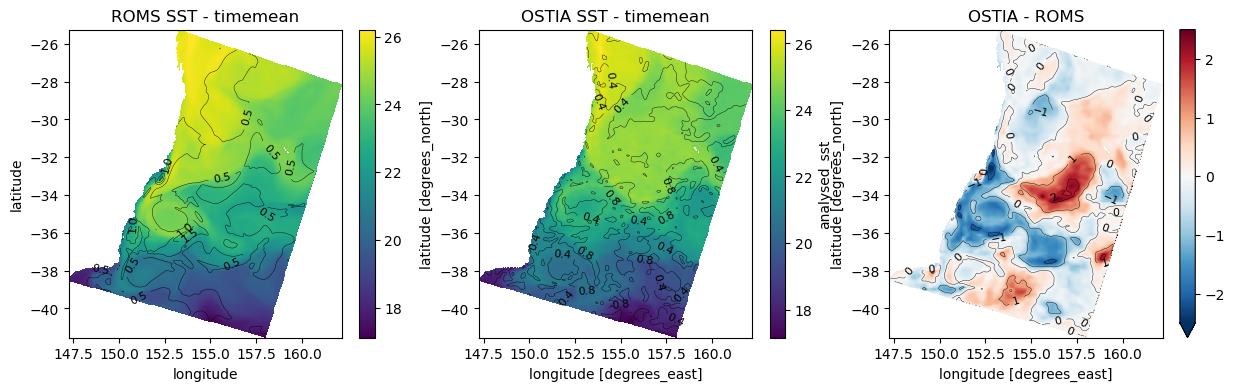

In [89]:
# Checking the timemean comparison

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

roms_timemean.plot(ax=ax[0])
cnt = roms_std.plot.contour(ax=ax[0], levels=5, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[0].set_title('ROMS SST - timemean')

ostia_timemean.plot(ax=ax[1])
cnt = ostia_std.plot.contour(ax=ax[1], levels=5, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[1].set_title('OSTIA SST - timemean');

diff_.plot(ax=ax[2], vmin=-2.5, vmax=2.5, cmap='RdBu_r')
cnt = diff_.plot.contour(ax=ax[2], levels=7, colors=['k'], linewidths=0.3)
plt.clabel(cnt, inline=True, fontsize=8)
ax[2].set_title('OSTIA - ROMS');

